## Effilab - business case

Comment : please download this notebook and work locally as several candidates can access it. Thank you.

Effilab bids on keywords on Google Ads for its around 10,000 clients. The goal is to achieve the number of conversions promised to the client while spending an optimal budget on adwords. Currently, we have a model optimizing budget and cpc bid (cost per click bid) at the campaign level.

One of our goal to optimize the cpc is to understand the evolution of conversions in function of clicks and impressions.

- **impression**: number of times the ads was shown by Google to a user. It depends, between other factors, on the cpc bid.
- **CPC**: cost per click
- **average_position**: average position (rank) in Google result pages. 
- **click**: when a user clicks on an ad
- **conversion**: when a user did a specific action on the client's website (for example filling a form to get info).

The csv 'dataset.csv' contains some data extracted from Google adwords. A first step will consist in extracting the dataset, checking the data and features that will help modelize the number of conversions. You can start with an exploratory analysis and some simple conclusions and modelization eventually.

### Environment

Librairires

- sklearn
- pandas
- dask
- numpy
- scipy
- matplotlib

If necessary, it is possible to install an external dependancy using `pip install <library>`

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [177]:
df = pd.read_csv(
    'dataset.csv',
    engine='python'
)

In [6]:
df.head()

,Unnamed: 0,customer_id,campaign_id,ad_group_id,keyword_id,keyword_text_matching_query,date,clicks,cost,impressions,conversions,avg_postion
0,0,1551288939,1484080226,56278671566,362396573757,+Décorateur +Peintre,2018-08-13,1,1.60,1,0.0,1.000000
1,1,1556604737,744170392,38463123585,94881345918,+Peinture +Niort,2018-08-24,1,0.94,1,0.0,2.000000
2,2,1559107978,1468647106,62493733088,389043783827,Taxi Remiremont,2018-08-02,3,1.76,5,0.0,1.000000
3,3,1568651041,1495197792,58813398638,376889097046,Serrurerie Merignac,2018-08-24,1,1.40,3,0.0,3.000000
4,4,1575898898,1078274555,53074066496,403784016698,Casse Automobile Guipavas,2018-08-14,2,0.41,7,0.0,2.128571


# General explorations

## supress first useless column (idem as index)

In [178]:
df = df.drop(['Unnamed: 0'],axis=1)

## number of informations

In [179]:
df.shape 
print('There are %0.0f observations and %0.0f features' %(df.shape[0],df.shape[1]))

There are 671614 observations and 11 features


In [180]:
df.nunique()

customer_id                     10117
campaign_id                     43804
ad_group_id                    208983
keyword_id                     131947
keyword_text_matching_query    109804
date                               31
clicks                             58
cost                             3775
impressions                       494
conversions                         4
avg_postion                      8939
dtype: int64

## check nan

In [232]:
for i in range(df.shape[1]) : 
    sum_na = df.iloc[:,i].isnull().sum()#.sum()
    if sum_na !=0 : print(df.columns[i])

avg_postion


There is empty values for the avg_position feature, let's check.

In [236]:
print('There is %0.0f observations for which there is no information about the avg_position' %len(df[df['avg_postion'].isnull()]))

There is 1266 observations for which there is no information about the avg_position


We will see what to do with these 1266 observations later (at modelisation part): 
    - whether to delete them 
    - whether to replace with mean value

# Exploration feature by feature

In [9]:
def feature_detail(df,feature,number) :
    df_ok = df.copy()
    df_ok[feature] = df_ok[feature].fillna('unknown')
    top_10 = df_ok.groupby(feature).agg('size').sort_values(ascending=False).to_frame().reset_index()
    top_10.columns=[str(x) for x in feature]+['nb_records']
    top_10['percentage']=(100.* (top_10['nb_records'] / top_10['nb_records'].sum())).round(2)
    print('%0.0f distinct values for the feature %s' %(top_10.shape[0],feature))
    return top_10.head(number)

In [181]:
print('There are %0.0f distinct dates' %len(df['date'].unique()))
#date of ad creation
df.loc[:,'date'] = pd.to_datetime(df.loc[:,'date'])
# create a feature representing the day 
df.loc[:,'date_day'] = df.loc[:,'date'].dt.day
# create a feature representing the day of week
df.loc[:,'date_dayofw'] = df.loc[:,'date'].dt.day_name()

min_created = min(df['date'])
max_created = max(df['date'])
print('Campaigns have been created from %s to %s' %(min_created.date(), max_created.date()))

There are 31 distinct dates
Campaigns have been created from 2018-08-01 to 2018-08-31


In [43]:
test = feature_detail(df,['campaign_id'],50000)
test['nb_records'].describe()

43804 distinct values for the feature ['campaign_id']


count    43804.000000
mean        15.332253
std         23.276624
min          1.000000
25%          3.000000
50%          7.000000
75%         19.000000
max       1095.000000
Name: nb_records, dtype: float64

There are 43 804 distinct campaign ids. Each campaign id have several ad groups and several keywords associated to the ad group. 
Thus, a campaign can have from 1 to around 1000 variations (depends of the date).

In [70]:
test = feature_detail(df,['campaign_id','ad_group_id'],50000)
test['nb_records'].describe()

208983 distinct values for the feature ['campaign_id', 'ad_group_id']


count    50000.000000
mean         8.914000
std          7.867722
min          3.000000
25%          4.000000
50%          6.000000
75%         10.000000
max        124.000000
Name: nb_records, dtype: float64

Each campaign is separated in ad groups : one campaign have on average 9 ad groups. 
It can reach more than 100 ad groups for a same campaign.

In [68]:
test = feature_detail(df,['campaign_id','ad_group_id','keyword_id','keyword_text_matching_query'],10)
print(test['nb_records'].describe())
test

312510 distinct values for the feature ['campaign_id', 'ad_group_id', 'keyword_id', 'keyword_text_matching_query']
count    10.0
mean     31.0
std       0.0
min      31.0
25%      31.0
50%      31.0
75%      31.0
max      31.0
Name: nb_records, dtype: float64


,campaign_id,ad_group_id,keyword_id,keyword_text_matching_query,nb_records,percentage
0,1425185730,53463909342,26733763551,+permis +voiture,31,0.0
1,1070528623,52792010285,370013849655,Pneus Pas Cher,31,0.0
2,1370691499,54510883157,351913403174,+machine +traite,31,0.0
3,1070531164,56926790560,370013849655,Pneus Pas Cher,31,0.0
4,1051571442,60770780091,177671636,Velux,31,0.0
5,1069704872,54444170876,370013849655,Pneus Pas Cher,31,0.0
6,1487469566,61577683870,350900819227,Contrôle Technique,31,0.0
7,1043226208,54500396293,296317284611,Constructeur Maison,31,0.0
8,1332823161,53743589926,350081959087,+Store +Banne,31,0.0
9,1471373693,54549270222,388547443604,Tirage tarot Amour,31,0.0


Each campaigns is seperated in different ad_group_id which are itselves separated by specific keywords.
During August 2018, There had been 312 510 different "enchères". Each "enchere" was made each day of august 2018, so during 31 days. However, the cost by click is changing each day for a same type of ad selection.

In [71]:
df.loc[(df['campaign_id']==1425185730)&
  (df['ad_group_id']==53463909342)&
  (df['keyword_id']==26733763551),['clicks','cost']]

,clicks,cost
12873,3,2.97
19582,3,4.00
19583,5,7.32
45855,6,8.63
109754,0,0.00
113191,2,3.13
130011,1,1.77
147070,0,0.00
153286,0,0.00
155341,0,0.00


# Keywords

In [27]:
feature_detail(df,['keyword_text_matching_query'],10)

109804 distinct values for the feature ['keyword_text_matching_query']


,keyword_text_matching_query,nb_records,percentage
0,Pneus Pas Cher,2081,0.31
1,Constructeur Maison,1405,0.21
2,Lissage Brésilien,1179,0.18
3,poele a granule,1161,0.17
4,+Motorisation +Portail,1005,0.15
5,poele a bois,966,0.14
6,Restaurant,955,0.14
7,Traiteur,887,0.13
8,Contrôle Technique,843,0.13
9,+Automobile +Garage,824,0.12


In [39]:
test = df['keyword_text_matching_query'].str.lower().str.split(' ')
feature_detail(df[df['keyword_text_matching_query'].str.contains('\+')==True],['keyword_text_matching_query'],10)

65193 distinct values for the feature ['keyword_text_matching_query']


,keyword_text_matching_query,nb_records,percentage
0,+Motorisation +Portail,1005,0.27
1,+Automobile +Garage,824,0.22
2,+Restaurant,788,0.21
3,+Traiteur,762,0.21
4,+funerarium,749,0.20
5,+Fosse +Septique,723,0.20
6,+Lissage +Brésilien,676,0.18
7,+Fioul +Domestique,662,0.18
8,+Fabricant +Portail,635,0.17
9,+Coiffeur +Pas +Cher,615,0.17


In [182]:
# contains some '+' or not 
df.loc[:,'keyword_+']=0
df.loc[df['keyword_text_matching_query'].str.contains('\+')==True,'keyword_+']=1
# contains a '++''
df.loc[:,'keyword_++']=0
df.loc[df['keyword_text_matching_query'].str.contains('\+\+')==True,'keyword_++']=1
# number of keywords
df.loc[:,'keyword_nb'] = df['keyword_text_matching_query'].str.split(' ')\
.apply(lambda x : len([i for i in x if i != '++']))

#df.loc[df['keyword_++']==1,['keyword_text_matching_query','keyword_nb_1']]

# impressions 

In [80]:
df['impressions'].describe()

count    671614.000000
mean          2.698785
std          17.301113
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max        4412.000000
Name: impressions, dtype: float64

One type of ad is visible on average 1 time. But there are a lot of outliers 25% of the campaigns are visible in google between 2 and 4000 times. Let's see percentles for more precisions.

In [83]:
df['impressions'].quantile([0.9,0.95,0.99])

0.90     4.0
0.95     6.0
0.99    23.0
Name: impressions, dtype: float64

Only 1% of ad researchs are visible more than 23 times. 
An ad research visible 4000 times seem weird, it is really far from the average.

In [93]:
df[df['impressions']==4412]

,Unnamed: 0,customer_id,campaign_id,ad_group_id,keyword_id,keyword_text_matching_query,date,clicks,cost,impressions,conversions,avg_postion,date_mth,date_day
549965,549965,2806996680,1343520888,63061628108,24283541,velux,2018-08-16,1,7.78,4412,0.0,1.00272,2018,16


# clicks

In [78]:
df['clicks'].describe()

count    671614.000000
mean          1.250647
std           1.142853
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         101.000000
Name: clicks, dtype: float64

In [94]:
df['clicks'].quantile([0.9])

0.9    2.0
Name: clicks, dtype: float64

The maximum number of clicks made for a research ad is 101. Though, 90% of ad researchs are clicked less than 2 times.

# cost

In [100]:
df.loc[df['cost']!=0,'cost'].describe()

count    617765.000000
mean          1.441263
std           2.106173
min           0.010000
25%           0.420000
50%           0.830000
75%           1.640000
max         133.840000
Name: cost, dtype: float64

In [101]:
df.loc[df['cost']==0,'clicks'].describe()

count    53849.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: clicks, dtype: float64

The cost can be 0 when there isn't any click made. Otherwise it is on average 1.4 euros by ad and it can reach round 100 euros.

In [147]:
df.clicks.values#.reshape(-1,1)

array([1, 1, 3, ..., 1, 0, 1])

Let's look at the relation between the cost and the number of click

In [102]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

regr = linear_model.LinearRegression()
X = df.clicks.values.reshape(-1,1)
y = df.cost.values.reshape(-1,1)
regr.fit(X, y)
print(regr.coef_[0])
print(regr.intercept_)
y_pred = regr.predict(X)
print("Mean squared error: %.2f"
      % mean_squared_error(y, y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y, y_pred))

[0.7779938]
[0.35270875]
Mean squared error: 3.44
Variance score: 0.19


/Users/paguilmin/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Relation betweeen number of clicks and cost')

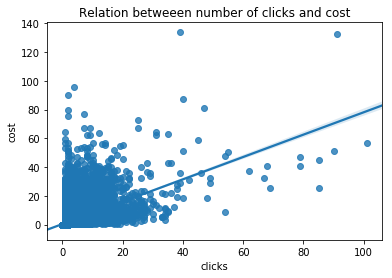

In [103]:
sns.regplot(x='clicks', y="cost", data=df)
plt.title('Relation betweeen number of clicks and cost')

# average position

In [88]:
df['avg_postion'].describe()

count    670348.000000
mean          2.002858
std           1.245060
min           1.000000
25%           1.000000
50%           1.714286
75%           3.000000
max          11.000000
Name: avg_postion, dtype: float64

Each ad research is on average the second link visible of google page. But, for 25% of ad research it is after the third links of google.

# conversion

In [89]:
df['conversions'].describe()

count    671614.000000
mean          0.013819
std           0.117806
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           3.000000
Name: conversions, dtype: float64

In [107]:
df['clicks'].quantile([0.8])

0.8    1.0
Name: clicks, dtype: float64

In [108]:
20/100*671614

134322.80000000002

The conversion is the indicator showing that the number of the client has been seen or the user has sent a request. Only 20% (134 322) ads are transformed in an attempt of contact.

In [144]:
df.columns

Index(['Unnamed: 0', 'customer_id', 'campaign_id', 'ad_group_id', 'keyword_id',
       'keyword_text_matching_query', 'date', 'clicks', 'cost', 'impressions',
       'conversions', 'avg_postion', 'date_mth', 'date_day', 'keyword_+',
       'keyword_++', 'keyword_nb_1'],
      dtype='object')

# Modelise the number of conversion

In [154]:
feature_detail(df,['conversions'],5)

4 distinct values for the feature ['conversions']


,conversions,nb_records,percentage
0,0.0,662414,98.63
1,1.0,9122,1.36
2,2.0,75,0.01
3,3.0,3,0.00


As we have really few examples of number conversions above 1.
We can just create a boolean feature for each ad (type of research and date). Hence, 1 will represent that the ad keywords this day have been trnsformed in a contact and 0 will represent that the ad keywords have not triggered an attempt of contact for the client.

## parameters

### nan parameters

But first let's deal with nan parameters in avg_position

In [241]:
print('Number of conversions when there is no information of avg position')
feature_detail(df[df['avg_postion'].isnull()],['conversions'],5)

Number of conversions when there is no information of avg position
2 distinct values for the feature ['conversions']


,conversions,nb_records,percentage
0,0.0,1254,99.05
1,1.0,12,0.95


As there is only 12 observations with conversions = 1 and no average position, we can decide to suppress them instead of choising a value (median for instance)

In [248]:
print('We had %0.0f observations before removing nan' %len(df))
df = df.dropna(subset=['avg_postion'])
print('We now have %0.0f observations after removing nan' %len(df))

We had 671614 observations before removing nan
We now have 670348 observations after removing nan


### get dummies : one hot encoding

And transform categorical feature in one hot encodings with get_dummies fonction 

In [249]:
df = df.reset_index(drop=True)
df = pd.concat([df,pd.get_dummies(df['date_dayofw'])],axis=1)
df = df.drop(['date_dayofw'],axis=1)

## feature to predict

In [250]:
df.loc[:,'conversion_ok'] = 0
df.loc[df['conversions']>=1,'conversion_ok'] = 1

In [251]:
feature_detail(df,['conversion_ok'],5)

2 distinct values for the feature ['conversion_ok']


,conversion_ok,nb_records,percentage
0,0,661160,98.63
1,1,9188,1.37


Now we have imbalanced data so let's just keep 9200 observations of ads that haven't been transformed into a contact.

## balance feature to predict

In [252]:
df = df.reset_index(drop=True)
df_1_sample = df[df['conversion_ok']==1]
import random
df_0_index = df[df['conversion_ok']==0].index
random_df_0_index = np.random.choice(df_0_index,int(sum(df['conversion_ok'])),replace=False)
df_0_sample = df.loc[random_df_0_index]

df_ok = pd.concat([df_1_sample,df_0_sample],axis=0)
print('Percentage of conversion done %0.1f' %(len(df_ok[df_ok['conversion_ok']==1])/len(df_ok)))
print('Percentage of conversion not done %0.1f' %(len(df_ok[df_ok['conversion_ok']==0])/len(df_ok)))
print('Number of records for df_ok %0.0f' %(len(df_ok)))
df_ok = df_ok.drop(['conversions','keyword_text_matching_query','date'],axis=1)

Percentage of conversion done 0.5
Percentage of conversion not done 0.5
Number of records for df_ok 18376


## shuffle data

Now that our prediction feature is well balanced we can shuffle it to improve the modelisation results afterwards.

In [253]:
df_ok = df_ok.loc[np.random.permutation(df_ok.index)]
df_ok = df_ok.reset_index(drop=True)

## correlations

Text(0.5, 1.0, 'Represents the correlations betweeen features')

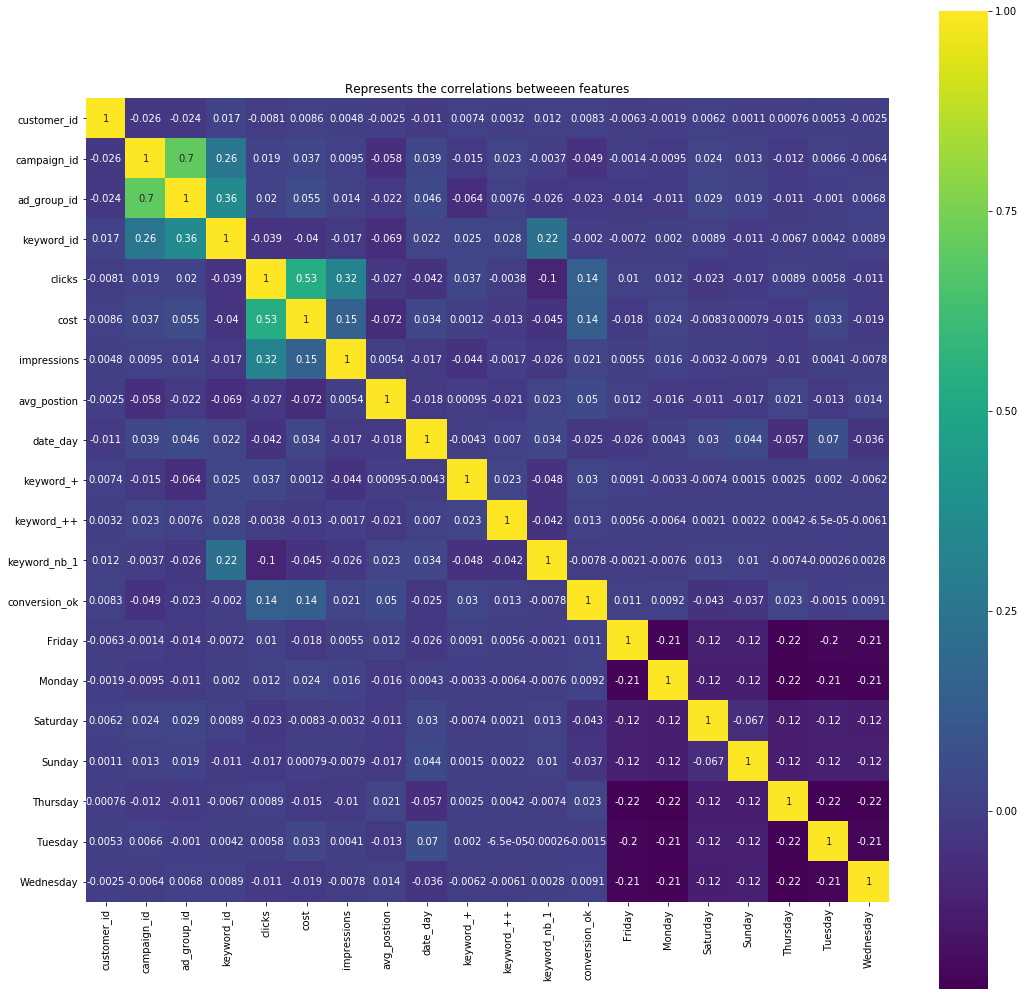

In [254]:
tab_corr = df_ok.corr()
plt.figure(figsize=(18, 18))
sns.heatmap(tab_corr, vmax=1, square=True,annot=True,cmap='viridis')
plt.title('Represents the correlations betweeen features')

## separate the parameters and the feature to predict

In [255]:
# features parameters
X = df_ok.loc[:, df_ok.columns != 'conversion_ok']
# feature to predict
y = df_ok.loc[:, df_ok.columns == 'conversion_ok']

## separate train test

In [256]:
df_ok.columns

Index(['customer_id', 'campaign_id', 'ad_group_id', 'keyword_id', 'clicks',
       'cost', 'impressions', 'avg_postion', 'date_day', 'keyword_+',
       'keyword_++', 'keyword_nb_1', 'conversion_ok', 'Friday', 'Monday',
       'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday'],
      dtype='object')

In [257]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [277]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(random_state=0, n_estimators=1000,max_depth=2)
#,
classifier.fit(X_train, y_train)

/Users/paguilmin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [278]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [279]:
y_pred = classifier.predict(X_test)

cm = confusion_matrix(y_test,y_pred)
print('Matrice de confusion')
print(cm)
print('Accuracy of lrandom forest : %0.02f' %(accuracy_score(y_test,y_pred)))

Matrice de confusion
[[1657 1106]
 [ 997 1753]]
Accuracy of lrandom forest : 0.62


AUC: 0.672


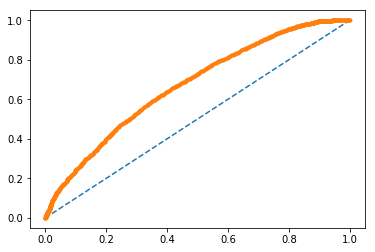

In [280]:
#from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
# predict probabilities
probs = classifier.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
auc = roc_auc_score(y_test, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
# show the plot
plt.show()

In [262]:
feature_importances = pd.DataFrame(classifier.feature_importances_,
                                   index = X.columns,
                                   columns=['importance']).sort_values('importance',ascending=False)
feature_importances

,importance
cost,0.162032
campaign_id,0.128531
customer_id,0.127829
keyword_id,0.127554
ad_group_id,0.126522
date_day,0.076124
avg_postion,0.051323
clicks,0.047500
keyword_nb_1,0.036558
impressions,0.027095


In [271]:
from sklearn import neighbors
clf2 = neighbors.KNeighborsClassifier()
clf2.fit(X, y)
y_pred2 = clf2.predict(X_test)
cm = confusion_matrix(y_test,y_pred2)
print('Matrice de confusion')
print(cm)
print('Accuracy of K-nearest neighbors : %0.02f' %(accuracy_score(y_test,y_pred2)))

Matrice de confusion
[[1937  826]
 [ 818 1932]]
Accuracy of lrandom forest : 0.70


/Users/paguilmin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


AUC: 0.769


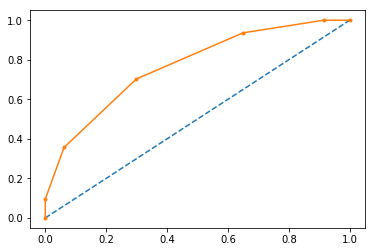

In [272]:
#from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
# predict probabilities
probs = clf2.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
auc = roc_auc_score(y_test, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
# show the plot
plt.show()